## Pre-requisites
Before running this notebook, make sure you have the following packages installed.
- ta-lib  
https://github.com/mrjbq7/ta-lib
- kaggle api  
https://github.com/Kaggle/kaggle-api

## Placeholder

In [12]:
import pandas as pd
import numpy as np
import talib
import os
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.finance as mpf
%matplotlib inline

### Download Kaggle datasets

In [2]:
!kaggle datasets download -d dgawlik/nyse -p ./datasets

nyse.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
fundamentals = pd.read_csv("./datasets/fundamentals.csv", parse_dates=['Period Ending'])
prices = pd.read_csv("./datasets/prices.csv", parse_dates=['date'])
prices_adj = pd.read_csv("./datasets/prices-split-adjusted.csv", parse_dates=['date'])
securities = pd.read_csv("./datasets/securities.csv", parse_dates=['Date first added'])

In [4]:
symbols = sorted(prices_adj['symbol'].unique())
prices_adj.set_index(['symbol', 'date'], inplace=True, drop=True)
prices_adj.sort_index(inplace=True)

### Normalize the prices entries using the t-1 close price  
Effectively it's the daily return calculated as the difference of the log(price)

In [5]:
log_ret = prices_adj.copy()

# Log transfrom the prices   
for col in ['open','close','low','high']:
    log_ret[col] = np.log(log_ret[col])
    
# Get the close price of the previous day
log_ret['close_m1'] = log_ret['close'].shift(1)

# Calculate normalize the prices using t-1 close price
log_ret.eval('''
                open = open - close_m1
                close = close - close_m1
                high = high - close_m1
                low = low - close_m1
             ''',
             inplace = True)

# Drop close_m1
log_ret.drop(labels=['close_m1'], axis='columns', inplace=True)

# Drop the first entry for each ticker
idx = log_ret.groupby('symbol').head(1).index
log_ret.drop(labels=idx, axis='index', inplace=True)

In [65]:
# Some feature engineering

for s in symbols[:3]:
    for period in [5, 10, 20, 30, 50]:
        
        # Momentum
        exec("""log_ret.loc[s, 'mom_%s'] = log_ret.loc[s, 'close'].rolling(period).sum().values"""  % period)

In [55]:
log_ret.loc[s, 'mom_5'] = log_ret.loc['A', 'close'].rolling(5).sum().values

In [67]:
log_ret.loc['A']

,open,close,low,high,volume,mom_5,mom_10,mom_20,mom_30,mom_50
date,,,,,,,,,,
2010-01-05,-0.002880,-0.010922,-0.017403,-0.002559,4186000.0,NaN,NaN,NaN,NaN,NaN
2010-01-06,-0.003559,-0.003559,-0.006481,0.001291,3243700.0,NaN,NaN,NaN,NaN,NaN
2010-01-07,-0.002272,-0.001298,-0.011410,-0.000973,3095100.0,NaN,NaN,NaN,NaN,NaN
2010-01-08,-0.005533,-0.000325,-0.013397,0.001298,3733900.0,NaN,NaN,NaN,NaN,NaN
2010-01-11,0.002594,0.000649,-0.004230,0.008084,4781500.0,-0.015454,NaN,NaN,NaN,NaN
2010-01-12,-0.008472,-0.012078,-0.019660,-0.005531,2871000.0,-0.016610,NaN,NaN,NaN,NaN
2010-01-13,0.000657,0.007851,-0.013223,0.010779,3418900.0,-0.005200,NaN,NaN,NaN,NaN
2010-01-14,-0.003264,0.014877,-0.006210,0.017762,6163700.0,0.010975,NaN,NaN,NaN,NaN
2010-01-15,0.002245,-0.023385,-0.026677,0.006719,4626600.0,-0.012086,NaN,NaN,NaN,NaN


In [58]:
log_ret.head(10)

open     close       low      high     volume  mom_5  \
symbol date                                                                   
A      2010-01-05 -0.002880 -0.010922 -0.017403 -0.002559  4186000.0    NaN   
       2010-01-06 -0.003559 -0.003559 -0.006481  0.001291  3243700.0    NaN   
       2010-01-07 -0.002272 -0.001298 -0.011410 -0.000973  3095100.0    NaN   
       2010-01-08 -0.005533 -0.000325 -0.013397  0.001298  3733900.0    NaN   
       2010-01-11  0.002594  0.000649 -0.004230  0.008084  4781500.0    NaN   
       2010-01-12 -0.008472 -0.012078 -0.019660 -0.005531  2871000.0    NaN   
       2010-01-13  0.000657  0.007851 -0.013223  0.010779  3418900.0    NaN   
       2010-01-14 -0.003264  0.014877 -0.006210  0.017762  6163700.0    NaN   
       2010-01-15  0.002245 -0.023385 -0.026677  0.006719  4626600.0    NaN   
       2010-01-19 -0.002303  0.012086 -0.002632  0.013059  3563600.0    NaN   

                   mom_10  mom_20  mom_30  mom_50  
symbol date                                        
A      2010-01-05     NaN     NaN     NaN     NaN  
       2010-01-06     NaN     NaN     NaN     NaN  
       2010-01-07     NaN     NaN     NaN     NaN  
       2010-01-08     NaN     NaN     NaN     NaN  
       2010-01-11     NaN     NaN     NaN     NaN  
       2010-01-12     NaN     NaN     NaN     NaN  
       2010-01-13     NaN     NaN     NaN     NaN  
       2010-01-14     NaN     NaN     NaN     NaN  
       2010-01-15     NaN     NaN     NaN     NaN  
       2010-01-19     NaN     NaN     NaN     NaN

In [17]:
log_ret.reset_index().set_index('symbol')

,date,open,close,low,high,volume
symbol,,,,,,
A,2010-01-05,-0.002880,-0.010922,-0.017403,-0.002559,4186000.0
A,2010-01-06,-0.003559,-0.003559,-0.006481,0.001291,3243700.0
A,2010-01-07,-0.002272,-0.001298,-0.011410,-0.000973,3095100.0
A,2010-01-08,-0.005533,-0.000325,-0.013397,0.001298,3733900.0
A,2010-01-11,0.002594,0.000649,-0.004230,0.008084,4781500.0
A,2010-01-12,-0.008472,-0.012078,-0.019660,-0.005531,2871000.0
A,2010-01-13,0.000657,0.007851,-0.013223,0.010779,3418900.0
A,2010-01-14,-0.003264,0.014877,-0.006210,0.017762,6163700.0
A,2010-01-15,0.002245,-0.023385,-0.026677,0.006719,4626600.0


In [6]:
log_ret.groupby('symbol').head(1).head(6)

,,open,close,low,high,volume
symbol,date,,,,,
A,2010-01-05,-0.002880,-0.010922,-0.017403,-0.002559,4186000.0
AAL,2010-01-05,0.004184,0.107246,-0.012658,0.118482,25212000.0
AAP,2010-01-05,-0.001983,-0.005961,-0.016480,-0.001735,1932400.0
AAPL,2010-01-05,0.002753,0.001727,-0.003558,0.007356,150476200.0
ABBV,2013-01-03,-0.003423,-0.008292,-0.027715,-0.003423,16739300.0
ABC,2010-01-05,0.000751,-0.007160,-0.009432,0.000751,2476800.0


### Plotting

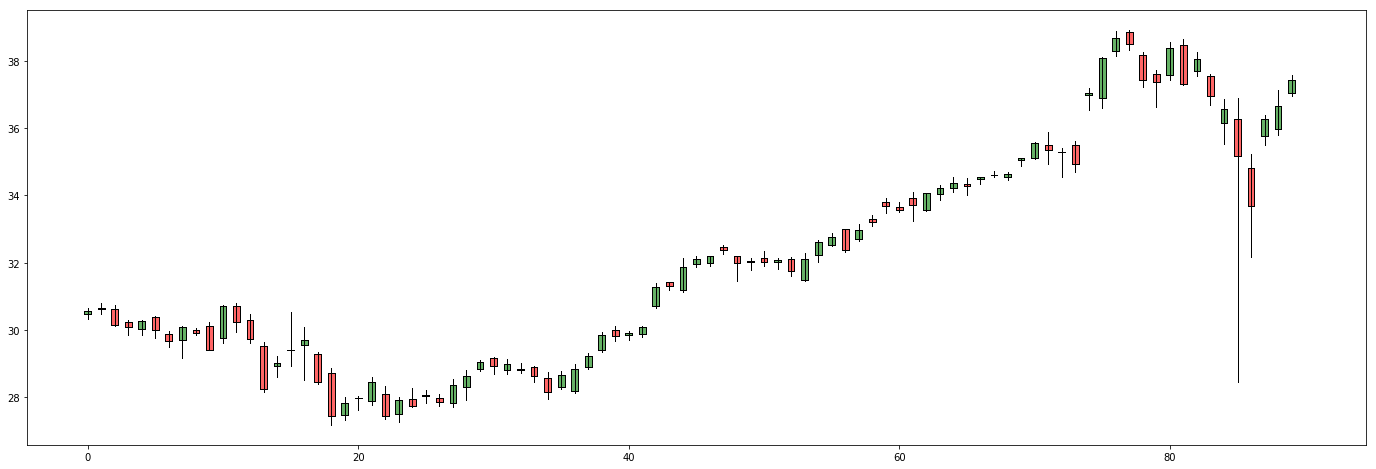

In [7]:
data = prices_adj.loc['AAPL', ['open','close','high','low','volume']][:90]
fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(1, 1, 1)
mpf.candlestick2_ochl(ax, data['open'], data['close'], data['high'], data['low'], width=0.5, colorup='green', colordown='red', alpha=0.6)

### Some technical analysis indicators

In [10]:
from talib.abstract import STOCH

In [13]:
for s in symbols[:5]:
    
    """ Momentum using close prices """
    prices_adj.loc[[s], 'MOM_20'] = talib.MOM(prices_adj.loc[[s], 'close'], timeperiod=20)
    
    """ Simple moving average of the close prices """
    prices_adj.loc[[s], 'MA_5'] = talib.SMA(prices_adj.loc[[s], 'close'], timeperiod=5)
    prices_adj.loc[[s], 'MA_10'] = talib.SMA(prices_adj.loc[[s], 'close'], timeperiod=10)
    prices_adj.loc[[s], 'MA_20'] = talib.SMA(prices_adj.loc[[s], 'close'], timeperiod=20)
    prices_adj.loc[[s], 'MA_50'] = talib.SMA(prices_adj.loc[[s], 'close'], timeperiod=50)
    prices_adj.loc[[s], 'MA_100'] = talib.SMA(prices_adj.loc[[s], 'close'], timeperiod=100)
    
    """ Bollinger bands """
    upper, middle, lower = talib.BBANDS(prices_adj.loc[[s], 'close'], matype=talib.MA_Type.T3)
    prices_adj.loc[[s], 'BBANDS.upper'] = upper
    prices_adj.loc[[s], 'BBANDS.middle'] = middle
    prices_adj.loc[[s], 'BBANDS.lower'] = lower
    
    """ Stochastic """
    # uses high, low, close (default)
    prices_adj.loc[[s], ['STOCH.slowk','STOCH.slowd']] = STOCH(prices_adj.loc[s], 5, 3, 0, 3, 0).as_matrix()

    # uses high, low, open instead
#     prices_adj.loc[[s], ['STOCH.slowk','STOCH.slowd']] = STOCH(prices_adj.loc[s], 5, 3, 0, 3, 0, 
#                                                                prices=['high', 'low', 'open']).as_matrix()

    

KeyError: "['STOCH.slowk' 'STOCH.slowd'] not in index"

In [21]:
## Calculate return

log_ret = pd.DataFrame()
log_ret.index = prices_adj.index

for s in symbols[:5]:
    prices_adj.loc[[s], 'close_t-1'] = prices_adj.loc[[s], 'close'].shift(1)
    
    log_ret.loc[s, ]

In [ ]:
pd.as_matrix()

In [123]:
talib.MA_Type.T3

8

In [124]:
?talib.BBANDS

In [117]:
upper, middle, lower = talib.BBANDS(prices_adj['close'], matype=talib.MA_Type.T3)

In [67]:
output = talib.MOM(prices_adj['close'], timeperiod=5)

In [72]:
sum(output.isnull())

5

### Split test and train data

#### Method 1: Hold off test data by each GICS sector  
- Hold off 20% ticker in each GICS sector

In [145]:
np.random.seed = 2018

train_ticks = []
test_ticks = []

for s in securities['GICS Sector'].unique():
    ticks = list(securities.loc[securities['GICS Sector']==s, 'Ticker symbol'])
    train, test = train_test_split(ticks, test_size=0.2, random_state=2018)
    train_ticks += train
    test_ticks += test
    
train_data = log_ret.loc[train_ticks]
test_data = log_ret.loc[test_ticks]

In [147]:
#### Method 2: Hold off latest observations as test set
- Hold off 20% ticker in each GICS sector

SyntaxError: invalid syntax (<ipython-input-147-65153ff25a21>, line 2)

In [165]:
log_ret.groupby(level=0).count()

,open,close,low,high,volume
symbol,,,,,
A,1761,1761,1761,1761,1761
AAL,1761,1761,1761,1761,1761
AAP,1761,1761,1761,1761,1761
AAPL,1761,1761,1761,1761,1761
ABBV,1007,1007,1007,1007,1007
ABC,1761,1761,1761,1761,1761
ABT,1761,1761,1761,1761,1761
ACN,1761,1761,1761,1761,1761
ADBE,1761,1761,1761,1761,1761


In [154]:
log_ret.index.levels[0]

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       ...
       'XLNX', 'XOM', 'XRAY', 'XRX', 'XYL', 'YHOO', 'YUM', 'ZBH', 'ZION',
       'ZTS'],
      dtype='object', name='symbol', length=501)

In [142]:
symbols[:3]

['A', 'AAL', 'AAP']

In [133]:
?train_test_split()

In [115]:
securities.groupby('GICS Sector')['Ticker symbol'].count()

GICS Sector
Consumer Discretionary         85
Consumer Staples               37
Energy                         36
Financials                     64
Health Care                    59
Industrials                    69
Information Technology         68
Materials                      25
Real Estate                    29
Telecommunications Services     5
Utilities                      28
Name: Ticker symbol, dtype: int64